# Detecting methods for LMS CNN and ESC-10
This notebook implements four different adversarial detection methods.
* KDE, BU: [repository](https://github.com/rfeinman/detecting-adversarial-samples), [repo-pytorch](https://github.com/Hyeongmin-Cho/Detecting-Adversarial-Samples-from-Artifacts-pytorch), [paper](https://arxiv.org/abs/1703.00410);
* LID: [repository](https://github.com/xingjunm/lid_adversarial_subspace_detection/tree/master), [paper](https://arxiv.org/abs/1801.02613);
* MD: [repository](https://github.com/pokaxpoka/deep_Mahalanobis_detector/tree/master), [paper](https://arxiv.org/abs/1807.03888).

Target model: [Ahmed et al 2020](https://www.researchgate.net/publication/344519283_Automatic_Environmental_Sound_Recognition_AESR_Using_Convolutional_Neural_Network)

Data: [ESC-10](https://github.com/karolpiczak/ESC-50)

In [368]:
import joblib
import random
import os
from math import ceil, floor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchsummary import summary

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score

from scipy.spatial.distance import cdist

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import librosa

In [12]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(SEED)

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [280]:
DATA_DIR = "Data"
DATASET = "ESC-10"

ADV_DATA_DIR = "Samples"
ADV_MODEL = "cnn_lms"

DATASET_PATH = os.path.join(DATA_DIR, DATASET)
META_PATH = os.path.join(DATASET_PATH, "meta", "esc10.csv")
AUDIO_PATH = os.path.join(DATASET_PATH, "audio")
ADV_DATA_PATH = os.path.join(ADV_DATA_DIR, ADV_MODEL)
ADV_META_PATH = os.path.join(ADV_DATA_PATH, "samples_meta.csv")

WEIGHTS_DIR = "Weights"

CHECKPT_PATH = os.path.join(WEIGHTS_DIR, "cnn_best.pth")

In [217]:
checkpoint = torch.load(CHECKPT_PATH)

In [218]:
SR = 16000

In [219]:
samples_type = ["Clean", "FGSM", "BIM", "DeepFool", "CW"]

## Preparing target model
___

In [220]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.l1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding="valid"),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(p=0.25),
            nn.ReLU()
        )

        self.l2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding="same"),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(p=0.25),
            nn.ReLU()
        )

        self.l3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding="same"),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(p=0.25),
            nn.ReLU()
        )

        self.l4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding="same"),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            nn.Dropout(p=0.25),
            nn.ReLU()
        )

        self.l5 = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=128 * 7 * 7, out_features=512),
            nn.ReLU()
        )

        self.l6 = nn.Sequential(
            nn.Dropout(p=0.6),
            nn.Linear(in_features=512, out_features=10)
        )
    
        self.sf = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.l1(input_data)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)

        logits = self.l6(x)
        probs = self.sf(logits)

        return logits, probs

In [221]:
cnn = CNN().to(device)
summary(cnn, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 126, 126]             160
         MaxPool2d-2           [-1, 16, 63, 63]               0
           Dropout-3           [-1, 16, 63, 63]               0
              ReLU-4           [-1, 16, 63, 63]               0
            Conv2d-5           [-1, 32, 63, 63]           4,640
         MaxPool2d-6           [-1, 32, 31, 31]               0
           Dropout-7           [-1, 32, 31, 31]               0
              ReLU-8           [-1, 32, 31, 31]               0
            Conv2d-9           [-1, 64, 31, 31]          18,496
        MaxPool2d-10           [-1, 64, 15, 15]               0
          Dropout-11           [-1, 64, 15, 15]               0
             ReLU-12           [-1, 64, 15, 15]               0
           Conv2d-13          [-1, 128, 15, 15]          73,856
        MaxPool2d-14            [-1, 12

In [222]:
model = CNN().to(device)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

## Preparing data
___
* Preparing original training dataset for KDE and MD.
* Downloading clean and adversarial images from the previous step. Splitting them into train and test subsets.
* Getting deep representations for KD.
* Choosing sigma for KD and k for LID.

In [388]:
def label_data(model, data, batch_size):
    labels = torch.zeros(len(data))
    num_batches = ceil(len(data) / batch_size)
    model.eval()
    for i in range(num_batches):
        start = i * batch_size
        end = np.minimum(len(data), (i + 1) * batch_size)
        data_batch = data[start: end].to(device)
        with torch.no_grad():
            _, outputs = model(data_batch)
        labels[start: end] = torch.argmax(outputs.cpu(), 1)
    
    return labels

In [282]:
def split_train_test(X, y):
    train_len = floor(len(X) * 70 / 100)
    return X[:train_len], X[train_len:], y[:train_len], y[train_len:]

In [283]:
def get_deep_representations(model, X, device, batch_size):
    model.eval()

    n_batches = ceil(X.shape[0] / batch_size)
    output = torch.zeros((len(X), 512))

    output_hidden = None

    def hook_fn(module, input, output):
        nonlocal output_hidden
        output_hidden = output

    list(model.modules())[-6].register_forward_hook(hook_fn)

    for i in tqdm(range(n_batches)):
        start = i * batch_size
        end = (i + 1) * batch_size
        if end > len(X):
            end = -1
        X_batch = X[start: end].to(device)

        with torch.no_grad():
            _ = model(X_batch)
        output[start: end] = output_hidden.detach().cpu()
    return output

In [284]:
X = {}

for type in samples_type:
    X[type] = torch.load(os.path.join(ADV_DATA_PATH, "_".join([type, "samples.pt"])))

In [285]:
target_to_label = {0: "dog", 41: "chainsaw", 12: "crackling_fire", 40: "helicopter", 10: "rain",
                   20: "crying_baby", 38: "clock_tick", 21: "sneezing", 1: "rooster", 11: "sea_waves"}
label_to_target = {"dog": 0, "chainsaw": 41, "crackling_fire": 12, "helicopter": 40, "rain": 10,
                   "crying_baby": 20, "clock_tick": 38, "sneezing": 21, "rooster": 1, "sea_waves": 11}
target_to_y = {0: 0, 41:1, 12: 2, 40: 3, 10: 4, 20: 5, 38: 6, 21: 7, 1: 8, 11: 9}
y_to_target = {0: 0, 1:41, 2: 12, 3: 40, 4: 10, 5: 20, 6: 38, 7: 21, 8: 1, 9: 11}

In [286]:
class ESC10(Dataset):
    def __init__(self, meta, transformation=None):
        self.meta = meta
        self.transformation = transformation

    def __len__(self):
        return len(self.meta)
    
    def __getitem__(self, index):
        spec = torch.from_numpy(self.meta.loc[index, "spectrogram"]).unsqueeze(0)
        if self.transformation is not None:
            spec = self.transformation(spec)
        target = self.meta.loc[index, "target"]

        return spec, target_to_y[target]

In [287]:
meta = pd.read_csv(META_PATH)
train_meta = meta[meta["fold"] != 5].drop(columns=["fold", "category", "src_file", "take"]).reset_index(drop=True)

spectrograms = []
for filename in train_meta["filename"]:
    wavpath = os.path.join(AUDIO_PATH, filename)
    waveform, _ = librosa.load(wavpath, sr=SR)
    mel = librosa.feature.melspectrogram(y=waveform, n_fft=1024, win_length=800, hop_length=400, sr=SR)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_db = librosa.util.fix_length(mel_db, size=128, axis=1)
    spectrograms.append(np.clip(mel_db, a_min=None, a_max=0.))

train_meta["spectrogram"] = spectrograms

In [288]:
tf_minmax = lambda x: (x + 80.) / 80.

In [289]:
train_data = ESC10(meta=train_meta, transformation=tf_minmax)
train_loader = DataLoader(train_data, batch_size=20, shuffle=False)

X_orig_train = torch.from_numpy(np.array([np.expand_dims(spec, 0) for spec in spectrograms]))
y_orig_train = torch.from_numpy(train_meta["target"].apply(lambda x: target_to_y[x]).to_numpy())

In [290]:
y = {type: label_data(model, X[type], batch_size=20) for type in samples_type}

In [291]:
X_train = {}
y_train = {}
X_test = {}
y_test = {}

for type in X.keys():
    X_train[type], X_test[type], y_train[type], y_test[type] = split_train_test(X[type], y[type])

In [292]:
X_test_df = {}
X_train_df = {}

for type in samples_type:
    X_train_df[type] = get_deep_representations(model, X_train[type], device, 20)
    X_test_df[type] = get_deep_representations(model, X_test[type], device, 20)

X_orig_train_df = get_deep_representations(model, X_orig_train, device, 20)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [341]:
param_grid = {
    "bandwidth": np.logspace(0.1, 1.0),
}

grid = GridSearchCV(KernelDensity(kernel="gaussian"), param_grid=param_grid, cv=4, verbose=True, n_jobs=-1)
grid.fit(X_orig_train_df.numpy())
grid.best_params_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


{'bandwidth': 10.0}

In [352]:
param_grid = {
    "n_clusters": range(2, 100),
}

grid = GridSearchCV(KMeans(), param_grid=param_grid, cv=4, verbose=True, n_jobs=-1)
grid.fit(X_orig_train.numpy().reshape((len(X_orig_train), -1)))
grid.best_params_

Fitting 4 folds for each of 98 candidates, totalling 392 fits


{'n_clusters': 50}

In [353]:
# listing rounded values of tuned parameters
sigma = 10.0
k = 50

## Detector interface

The structure of the following framework is based on [this repository](https://github.com/rfeinman/detecting-adversarial-samples/tree/master).

In [354]:
def form_detection_data(features_neg, features_pos, ndim=False):
    if not ndim:
        values_neg = features_neg.reshape(1, -1).transpose(1, 0)
        values_pos = features_pos.reshape(1, -1).transpose(1, 0)
    else:
        values_neg = features_neg
        values_pos = features_pos
    
    values = torch.cat((values_neg, values_pos))
    labels = torch.cat((torch.zeros_like(values_neg[:, 0]), torch.ones_like(values_pos[:, 0])))
    
    return values, labels

In [369]:
def train_detector(values, labels):
    
    pipe = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegressionCV(n_jobs=-1))])

    pipe.fit(values, labels)
    
    return pipe

In [356]:
def compute_roc(y_true, y_pred, plot=False):
    """
    TODO
    :param y_true: ground truth
    :param y_pred: predictions
    :param plot:
    :return:
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred)
    if plot:
        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='blue',
                 label='ROC (AUC = %0.4f)' % auc_score)
        plt.legend(loc='lower right')
        plt.title("ROC Curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

    return fpr, tpr, auc_score

## Kernel Density Estimation

In [370]:
def score_densities(features, labels, kdes):
    densities = torch.empty(0)
    for i in range(labels.shape[0]):
        class_label = labels[i].item()
        densities = torch.cat((densities, torch.from_numpy(kdes[class_label].score_samples(features[i].reshape((1, -1)).cpu().detach().numpy()))))
    return densities

In [371]:
class_indices = {}
kdes = {}

for i in range(10):
    class_indices[i] = np.where(y_orig_train == i)

for i in range(10):
    kdes[i] = KernelDensity(kernel='gaussian', bandwidth=sigma).fit(X_orig_train_df[class_indices[i]].cpu().detach().numpy())

In [372]:
densities_train = {}
densities_test = {}

for type in samples_type:
    densities_train[type] = score_densities(X_train_df[type], y_train[type], kdes)
    densities_test[type] = score_densities(X_test_df[type], y_test[type], kdes)

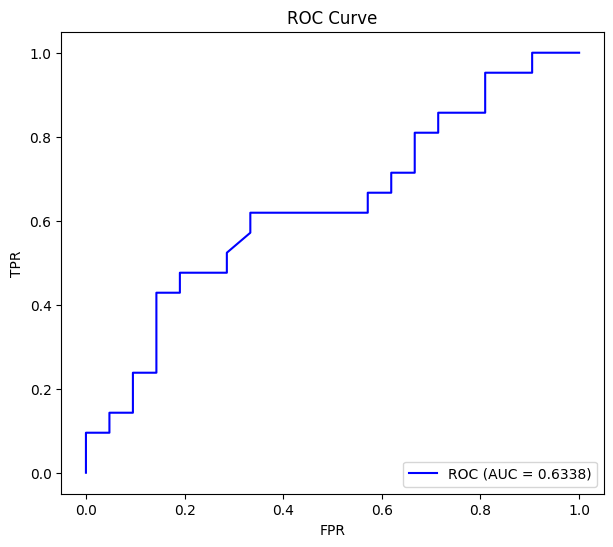

In [373]:
values_train_fgsm, labels_train_fgsm = form_detection_data(densities_train["Clean"], densities_train["FGSM"])
values_test_fgsm, labels_test_fgsm = form_detection_data(densities_test["Clean"], densities_test["FGSM"])
detector_fgsm_kde = train_detector(values_train_fgsm, labels_train_fgsm)
probs = torch.tensor(detector_fgsm_kde.predict_proba(values_test_fgsm)[:, 1])
fpr_kd_fgsm, tpr_kd_fgsm, auc_score_kd_fgsm = compute_roc(labels_test_fgsm, probs, plot=True)

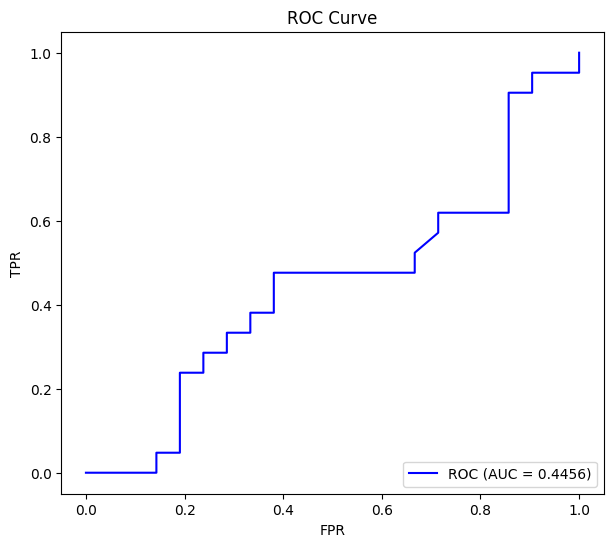

In [374]:
values_train_bim, labels_train_bim = form_detection_data(densities_train["Clean"], densities_train["BIM"])
values_test_bim, labels_test_bim = form_detection_data(densities_test["Clean"], densities_test["BIM"])
detector_bim_kde = train_detector(values_train_bim, labels_train_bim)
probs = torch.tensor(detector_bim_kde.predict_proba(values_test_bim)[:, 1])
fpr_kd_bim, tpr_kd_bim, auc_score_kd_bim = compute_roc(labels_test_bim, probs, plot=True)

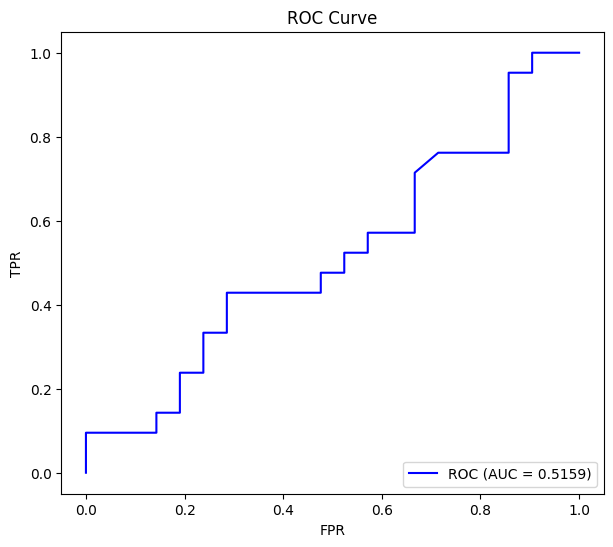

In [375]:
values_train_deepfool, labels_train_deepfool = form_detection_data(densities_train["Clean"], densities_train["DeepFool"])
values_test_deepfool, labels_test_deepfool = form_detection_data(densities_test["Clean"], densities_test["DeepFool"])
detector_deepfool_kde = train_detector(values_train_deepfool, labels_train_deepfool)
probs = torch.tensor(detector_deepfool_kde.predict_proba(values_test_deepfool)[:, 1])
fpr_kd_deepfool, tpr_kd_deepfool, auc_score_kd_deepfool = compute_roc(labels_test_deepfool, probs, plot=True)

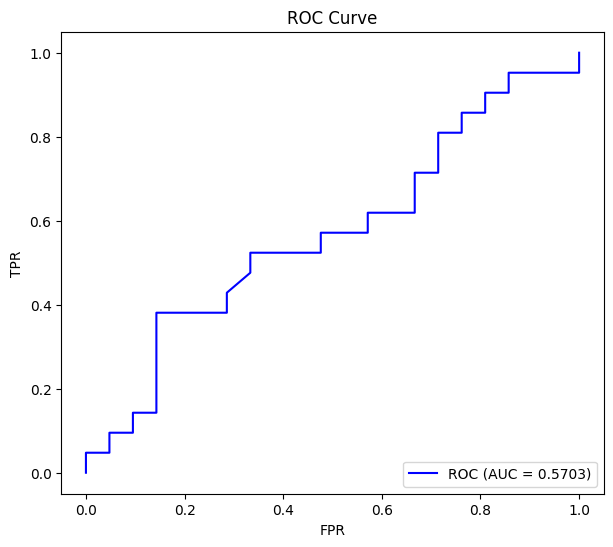

In [376]:
values_train_cw, labels_train_cw = form_detection_data(densities_train["Clean"], densities_train["CW"])
values_test_cw, labels_test_cw = form_detection_data(densities_test["Clean"], densities_test["CW"])
detector_cw_kde = train_detector(values_train_cw, labels_train_cw)
probs = torch.tensor(detector_cw_kde.predict_proba(values_test_cw)[:, 1])
fpr_kd_cw, tpr_kd_cw, auc_score_kd_cw = compute_roc(labels_test_cw, probs, plot=True)

## Bayesian uncertainty

In [380]:
def get_mc_predictions(model, data, batch_size, num_iter=50):
    output_dim = 10

    model.train()

    def predict():
        num_batches = ceil(data.shape[0] / batch_size)
        output = torch.zeros(size=(data.shape[0], output_dim))
        with torch.no_grad():
            for i in range(num_batches):
                start = i * batch_size
                end = np.minimum(data.shape[0], (i + 1) * batch_size)
                data_batch = data[start: end].to(device)
                _, output[start: end] = model(data_batch)

        return output

    predictions_mc = torch.empty(0, data.shape[0], output_dim)

    for _ in range(num_iter):
        predictions_mc = torch.cat((predictions_mc, predict().unsqueeze(0)))

    return predictions_mc

In [382]:
uncerts_train = {}
uncerts_test = {}

for type in samples_type:
    uncerts_train[type] = get_mc_predictions(model, X_train[type], batch_size=20).var(dim=0).mean(dim=1)
    uncerts_test[type] = get_mc_predictions(model, X_test[type], batch_size=20).var(dim=0).mean(dim=1)

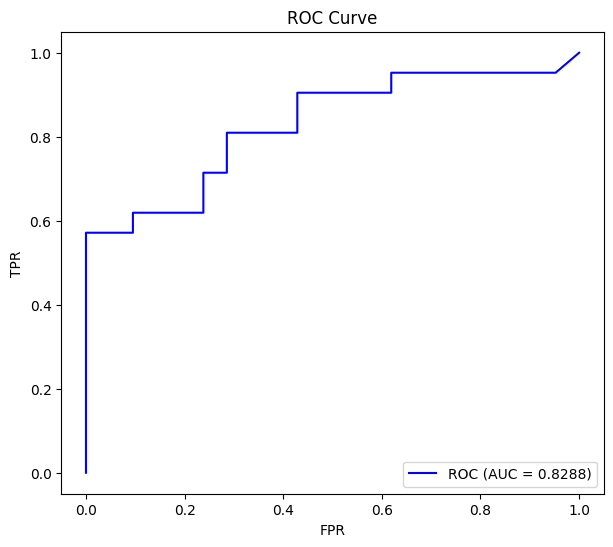

In [383]:
values_train_fgsm, labels_train_fgsm = form_detection_data(uncerts_train["Clean"], uncerts_train["FGSM"])
values_test_fgsm, labels_test_fgsm = form_detection_data(uncerts_test["Clean"], uncerts_test["FGSM"])
detector_fgsm_bu = train_detector(values_train_fgsm, labels_train_fgsm)
probs = torch.tensor(detector_fgsm_bu.predict_proba(values_test_fgsm)[:, 1])
fpr_bu_fgsm, tpr_bu_fgsm, auc_score_bu_fgsm = compute_roc(labels_test_fgsm, probs, plot=True)

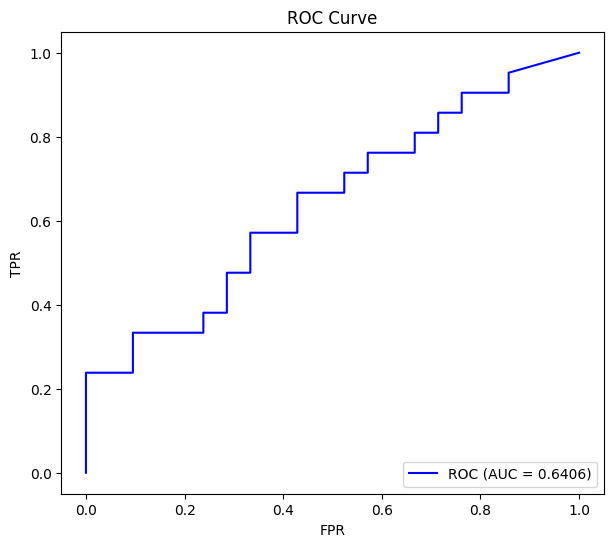

In [385]:
values_train_bim, labels_train_bim = form_detection_data(uncerts_train["Clean"], uncerts_train["BIM"])
values_test_bim, labels_test_bim = form_detection_data(uncerts_test["Clean"], uncerts_test["BIM"])
detector_bim_bu = train_detector(values_train_bim, labels_train_bim)
probs = torch.tensor(detector_bim_bu.predict_proba(values_test_bim)[:, 1])
fpr_bu_bim, tpr_bu_bim, auc_score_bu_bim = compute_roc(labels_test_bim, probs, plot=True)

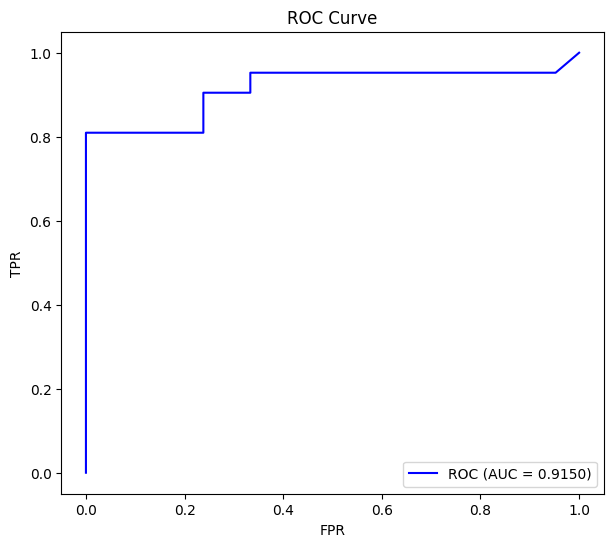

In [386]:
values_train_deepfool, labels_train_deepfool = form_detection_data(uncerts_train["Clean"], uncerts_train["DeepFool"])
values_test_deepfool, labels_test_deepfool = form_detection_data(uncerts_test["Clean"], uncerts_test["DeepFool"])
detector_deepfool_bu = train_detector(values_train_deepfool, labels_train_deepfool)
probs = torch.tensor(detector_deepfool_bu.predict_proba(values_test_deepfool)[:, 1])
fpr_bu_deepfool, tpr_bu_deepfool, auc_score_bu_deepfool = compute_roc(labels_test_deepfool, probs, plot=True)

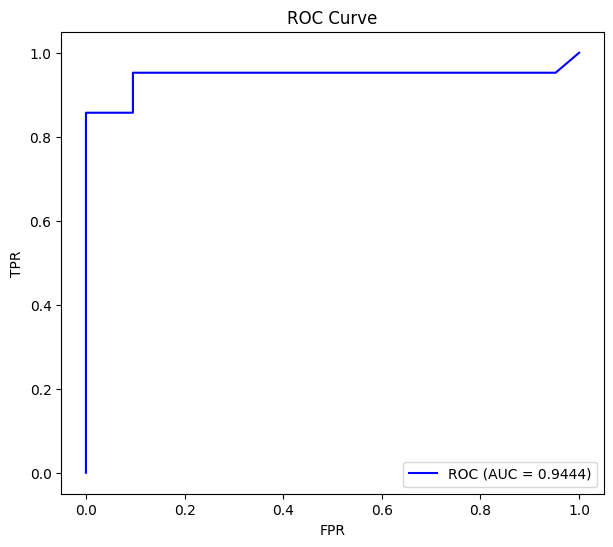

In [387]:
values_train_cw, labels_train_cw = form_detection_data(uncerts_train["Clean"], uncerts_train["CW"])
values_test_cw, labels_test_cw = form_detection_data(uncerts_test["Clean"], uncerts_test["CW"])
detector_cw_bu = train_detector(values_train_cw, labels_train_cw)
probs = torch.tensor(detector_cw_bu.predict_proba(values_test_cw)[:, 1])
fpr_bu_cw, tpr_bu_cw, auc_score_bu_cw = compute_roc(labels_test_cw, probs, plot=True)

## Local intrinsic dimensionality

In [409]:
def get_softmax_batch(model, X):
    with torch.no_grad():
        _, output = model(X.to(device))
    return output

In [428]:
def mle_batch(data, batch, k):
    data = torch.asarray(data, dtype=torch.float32).cpu()
    batch = torch.asarray(batch, dtype=torch.float32).cpu()

    k = min(k, len(data) - 1)
    f = lambda v: - k / np.sum(np.log(v/v[-1]))
    a = cdist(batch, data)
    a = np.apply_along_axis(np.sort, axis=1, arr=a)[:,1:k+1]
    a = np.apply_along_axis(f, axis=1, arr=a)
    return torch.from_numpy(a)

In [429]:
def get_lids_batch(model, X_clean, X_dest, k):
    lids_batch = torch.zeros(len(X_clean))
    X_softmax = get_softmax_batch(model, X_clean)
    X_softmax_dest = get_softmax_batch(model, X_dest)
    lids_batch = mle_batch(X_softmax, X_softmax_dest, k=k)
    
    return lids_batch

In [430]:
def get_lids(model, X, k, batch_size):
    lids = {type:torch.zeros(len(X[type])) for type in X.keys()}
    
    n_batches = ceil(X["Clean"].shape[0] / batch_size)
    for i in tqdm(range(n_batches)):
        start = i * batch_size
        end = np.minimum(len(X["Clean"]), (i + 1) * batch_size)

        for type in X.keys():
            lids_batch = get_lids_batch(model, X["Clean"][start: end], X[type][start: end], k)
            lids[type][start: end] = lids_batch

    return lids

In [436]:
lids_train = get_lids(model, X_train, k, batch_size=20)
lids_test = get_lids(model, X_test, k, batch_size=7)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

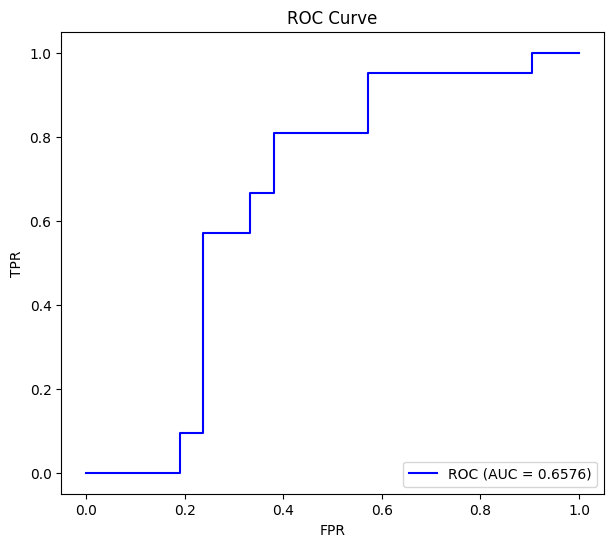

In [437]:
values_train_fgsm, labels_train_fgsm = form_detection_data(lids_train["Clean"], lids_train["FGSM"])
values_test_fgsm, labels_test_fgsm = form_detection_data(lids_test["Clean"], lids_test["FGSM"])
detector_fgsm_lid = train_detector(values_train_fgsm, labels_train_fgsm)
probs = torch.tensor(detector_fgsm_lid.predict_proba(values_test_fgsm)[:, 1])
fpr_lid_fgsm, tpr_lid_fgsm, auc_score_lid_fgsm = compute_roc(labels_test_fgsm, probs, plot=True)

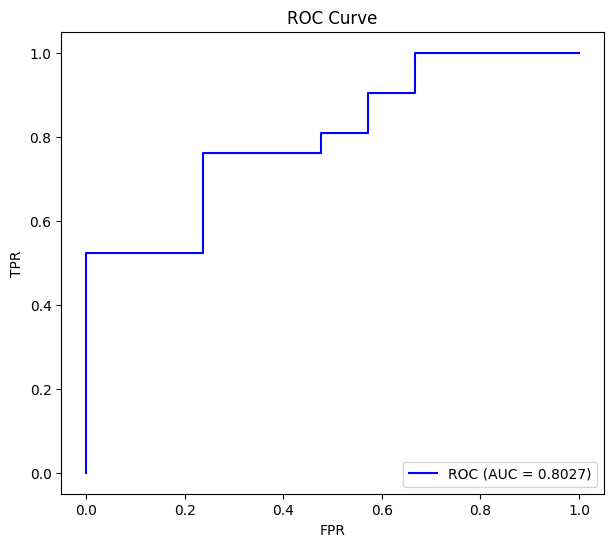

In [438]:
values_train_bim, labels_train_bim = form_detection_data(lids_train["Clean"], lids_train["BIM"])
values_test_bim, labels_test_bim = form_detection_data(lids_test["Clean"], lids_test["BIM"])
detector_bim_lid = train_detector(values_train_bim, labels_train_bim)
probs = torch.tensor(detector_bim_lid.predict_proba(values_test_bim)[:, 1])
fpr_lid_bim, tpr_lid_bim, auc_score_lid_bim = compute_roc(labels_test_bim, probs, plot=True)

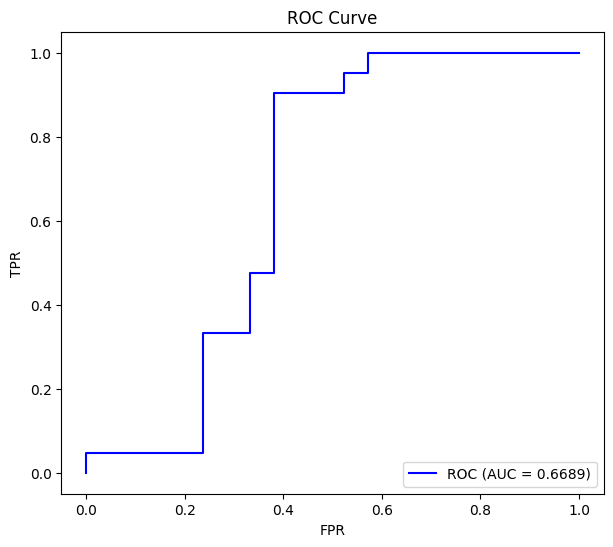

In [439]:
values_train_deepfool, labels_train_deepfool = form_detection_data(lids_train["Clean"], lids_train["DeepFool"])
values_test_deepfool, labels_test_deepfool = form_detection_data(lids_test["Clean"], lids_test["DeepFool"])
detector_deepfool_lid = train_detector(values_train_deepfool, labels_train_deepfool)
probs = torch.tensor(detector_deepfool_lid.predict_proba(values_test_deepfool)[:, 1])
fpr_lid_deepfool, tpr_lid_deepfool, auc_score_lid_deepfool = compute_roc(labels_test_deepfool, probs, plot=True)

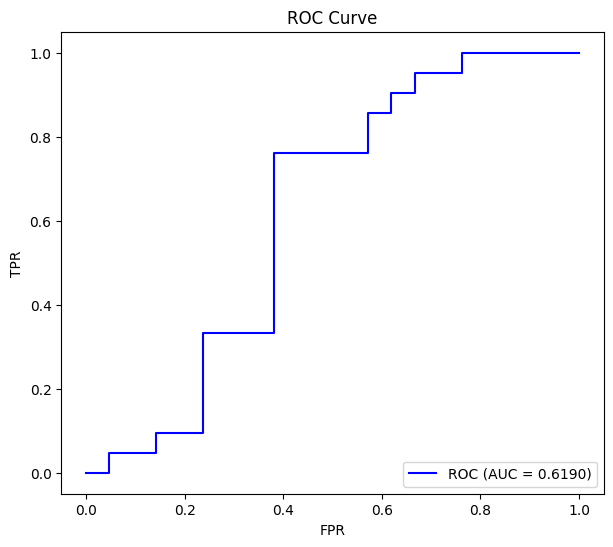

In [440]:
values_train_cw, labels_train_cw = form_detection_data(lids_train["Clean"], lids_train["CW"])
values_test_cw, labels_test_cw = form_detection_data(lids_test["Clean"], lids_test["CW"])
detector_cw_lid = train_detector(values_train_cw, labels_train_cw)
probs = torch.tensor(detector_cw_lid.predict_proba(values_test_cw)[:, 1])
fpr_lid_cw, tpr_lid_cw, auc_score_lid_cw = compute_roc(labels_test_cw, probs, plot=True)

## Mahalanobis distance

In [52]:
def sample_estimator(model, num_classes, feature_list, train_loader, device):
    """
    compute sample mean and precision (inverse of covariance)
    return: sample_class_mean: list of class mean
             precision: list of precisions
    """
    import sklearn.covariance
    
    model.eval()
    group_lasso = sklearn.covariance.EmpiricalCovariance(assume_centered=False)
    correct, total = 0, 0
    num_output = len(feature_list)
    num_sample_per_class = np.empty(num_classes)
    num_sample_per_class.fill(0)
    list_features = []
    for i in range(num_output):
        temp_list = []
        for j in range(num_classes):
            temp_list.append(0)
        list_features.append(temp_list)
    
    for data, target in train_loader:
        total += data.size(0)
        data = data.to(device)
        output, out_features = model.hidden_output_list(data)
        
        # get hidden features
        for i in range(num_output):
            out_features[i] = out_features[i].view(out_features[i].size(0), out_features[i].size(1), -1)
            out_features[i] = torch.mean(out_features[i].data, 2)
            
        # compute the accuracy
        pred = output.data.max(1)[1]
        equal_flag = pred.eq(target.cuda()).cpu()
        correct += equal_flag.sum()
        
        # construct the sample matrix
        for i in range(data.size(0)):
            label = target[i]
            if num_sample_per_class[label] == 0:
                out_count = 0
                for out in out_features:
                    list_features[out_count][label] = out[i].view(1, -1)
                    out_count += 1
            else:
                out_count = 0
                for out in out_features:
                    list_features[out_count][label] \
                    = torch.cat((list_features[out_count][label], out[i].view(1, -1)), 0)
                    out_count += 1                
            num_sample_per_class[label] += 1
            
    sample_class_mean = []
    out_count = 0
    for num_feature in feature_list:
        temp_list = torch.Tensor(num_classes, int(num_feature)).to(device)
        for j in range(num_classes):
            temp_list[j] = torch.mean(list_features[out_count][j], 0)
        sample_class_mean.append(temp_list)
        out_count += 1
        
    precision = []
    for k in range(num_output):
        X = 0
        for i in range(num_classes):
            if i == 0:
                X = list_features[k][i] - sample_class_mean[k][i]
            else:
                X = torch.cat((X, list_features[k][i] - sample_class_mean[k][i]), 0)
                
        # find inverse            
        group_lasso.fit(X.cpu().numpy())
        temp_precision = group_lasso.precision_
        temp_precision = torch.from_numpy(temp_precision).float().to(device)
        precision.append(temp_precision)
        
    print('\n Training Accuracy:({:.2f}%)\n'.format(100. * correct / total))

    return sample_class_mean, precision

In [53]:
def get_Mahalanobis_score_adv(model, test_data, test_label, num_classes, sample_mean, precision, layer_index, device, magnitude = 0):
    '''
    Compute the proposed Mahalanobis confidence score on adversarial samples
    return: Mahalanobis score from layer_index
    '''
    model.eval()
    Mahalanobis = []
    batch_size = 100
    total = 0
    
    for data_index in range(int(np.floor(test_data.size(0)/batch_size))):
        target = test_label[total : total + batch_size].to(device)
        data = test_data[total : total + batch_size].to(device)
        total += batch_size
        data, target = data.requires_grad_(True), target
        
        out_features = model.get_hidden_layer_output(data, layer_index)
        out_features = out_features.view(out_features.size(0), out_features.size(1), -1)
        out_features = torch.mean(out_features, 2)
        
        gaussian_score = 0
        for i in range(num_classes):
            batch_sample_mean = sample_mean[layer_index][i]
            zero_f = out_features.data - batch_sample_mean
            term_gau = -0.5*torch.mm(torch.mm(zero_f, precision[layer_index]), zero_f.t()).diag()
            if i == 0:
                gaussian_score = term_gau.view(-1,1)
            else:
                gaussian_score = torch.cat((gaussian_score, term_gau.view(-1,1)), 1)
        
        # Input_processing
        sample_pred = gaussian_score.max(1)[1]
        batch_sample_mean = sample_mean[layer_index].index_select(0, sample_pred)
        zero_f = out_features - batch_sample_mean
        pure_gau = -0.5*torch.mm(torch.mm(zero_f, precision[layer_index]), zero_f.t()).diag()
        loss = torch.mean(-pure_gau)
        loss.backward()
         
        gradient =  torch.ge(data.grad.data, 0)
        gradient = (gradient.float() - 0.5) * 2
        gradient.index_copy_(1, torch.LongTensor([0]).to(device), gradient.index_select(1, torch.LongTensor([0]).to(device)) / (0.2023))
        gradient.index_copy_(1, torch.LongTensor([1]).to(device), gradient.index_select(1, torch.LongTensor([1]).to(device)) / (0.1994))
        gradient.index_copy_(1, torch.LongTensor([2]).to(device), gradient.index_select(1, torch.LongTensor([2]).to(device)) / (0.2010))
        tempInputs = torch.add(data.data, -magnitude, gradient)
 
        noise_out_features = model.get_hidden_layer_output(tempInputs, layer_index)
        noise_out_features = noise_out_features.view(noise_out_features.size(0), noise_out_features.size(1), -1)
        noise_out_features = torch.mean(noise_out_features, 2)
        noise_gaussian_score = 0
        for i in range(num_classes):
            batch_sample_mean = sample_mean[layer_index][i]
            zero_f = noise_out_features.data - batch_sample_mean
            term_gau = -0.5*torch.mm(torch.mm(zero_f, precision[layer_index]), zero_f.t()).diag()
            if i == 0:
                noise_gaussian_score = term_gau.view(-1,1)
            else:
                noise_gaussian_score = torch.cat((noise_gaussian_score, term_gau.view(-1,1)), 1)      

        noise_gaussian_score, _ = torch.max(noise_gaussian_score, dim=1)
        Mahalanobis.extend(noise_gaussian_score.cpu().numpy())
        
    return Mahalanobis

In [54]:
# following the original implementation, find parmeters for scoring

model.eval()
temp_x = torch.rand(2,3,32,32).to(device)
temp_list = model.hidden_output_list(temp_x)[1]
num_output = len(temp_list)
feature_list = np.empty(num_output)
count = 0
for out in temp_list:
    feature_list[count] = out.size(1)
    count += 1

sample_mean, precision = sample_estimator(model, 10, feature_list, train_loader, device)


 Training Accuracy:(98.87%)



In [55]:
def get_md(model, X, y, sample_mean, precision, num_output, device):
    for i in range(num_output):
        M_out = get_Mahalanobis_score_adv(model, X, y, 10, \
                                            sample_mean, precision, i, device=device)
        M_out = torch.asarray(M_out, dtype=torch.float32)
        if i == 0:
            Mahalanobis_out = M_out.reshape((M_out.shape[0], -1))
        else:
            Mahalanobis_out = torch.cat((Mahalanobis_out, M_out.reshape((M_out.shape[0], -1))), dim=1)
                           
    return torch.asarray(Mahalanobis_out, dtype=torch.float32)

In [56]:
md_clean_train = get_md(model, X_clean_train, y_clean_train, sample_mean, precision, num_output, device)
md_clean_test = get_md(model, X_clean_train, y_clean_train, sample_mean, precision, num_output, device)
md_fgsm_train = get_md(model, X_fgsm_train, y_fgsm_train, sample_mean, precision, num_output, device)
md_fgsm_test = get_md(model, X_fgsm_test, y_fgsm_test, sample_mean, precision, num_output, device)
md_bim_train = get_md(model, X_bim_train, y_bim_train, sample_mean, precision, num_output, device)
md_bim_test = get_md(model, X_bim_test, y_bim_test, sample_mean, precision, num_output, device)
md_deepfool_train = get_md(model, X_deepfool_train, y_deepfool_train, sample_mean, precision, num_output, device)
md_deepfool_test = get_md(model, X_deepfool_test, y_deepfool_test, sample_mean, precision, num_output, device)
md_cw_train = get_md(model, X_cw_train, y_cw_train, sample_mean, precision, num_output, device)
md_cw_test = get_md(model, X_cw_test, y_cw_test, sample_mean, precision, num_output, device)

/tmp/ipykernel_2834/2001806072.py:44: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out) (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/torch/csrc/utils/python_arg_parser.cpp:1485.)
  tempInputs = torch.add(data.data, -magnitude, gradient)


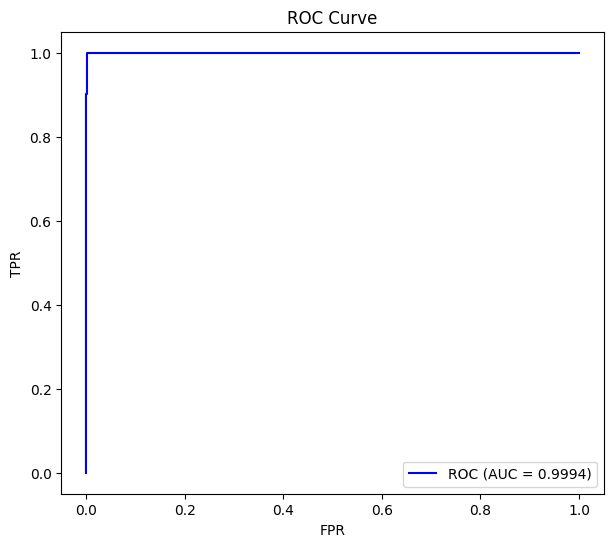

In [57]:
values_train_fgsm, labels_train_fgsm = form_detection_data(md_clean_train, md_fgsm_train, ndim=True)
values_test_fgsm, labels_test_fgsm = form_detection_data(md_clean_test, md_fgsm_test, ndim=True)
detector_fgsm_md = train_detector(values_train_fgsm, labels_train_fgsm)
probs = torch.tensor(detector_fgsm_md.predict_proba(values_test_fgsm)[:, 1])
fpr_md_fgsm, tpr_md_fgsm, auc_score_md_fgsm = compute_roc(labels_test_fgsm, probs, plot=True)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


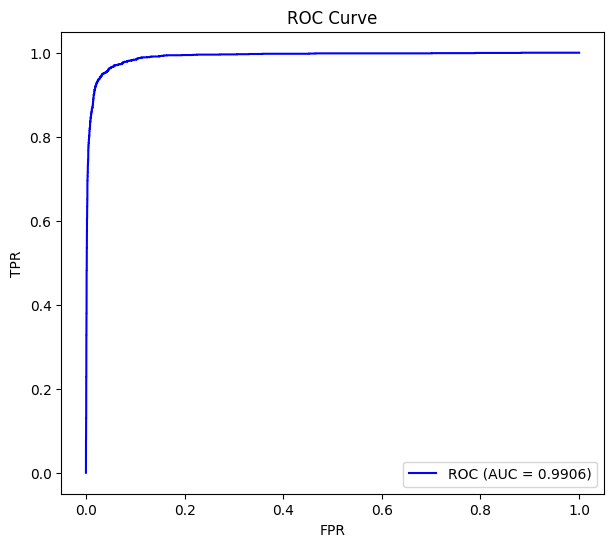

In [58]:
values_train_bim, labels_train_bim = form_detection_data(md_clean_train, md_bim_train, ndim=True)
values_test_bim, labels_test_bim = form_detection_data(md_clean_test, md_bim_test, ndim=True)
detector_bim_md = train_detector(values_train_bim, labels_train_bim)
probs = torch.tensor(detector_bim_md.predict_proba(values_test_bim)[:, 1])
fpr_md_bim, tpr_md_bim, auc_score_md_bim = compute_roc(labels_test_bim, probs, plot=True)

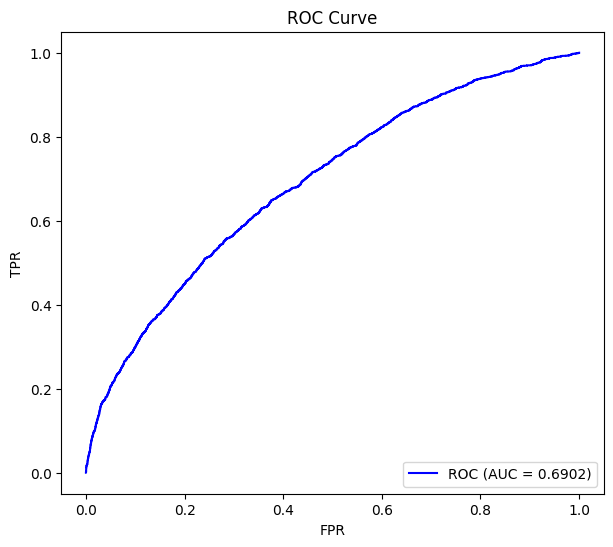

In [59]:
values_train_deepfool, labels_train_deepfool = form_detection_data(md_clean_train, md_deepfool_train, ndim=True)
values_test_deepfool, labels_test_deepfool = form_detection_data(md_clean_test, md_deepfool_test, ndim=True)
detector_deepfool_md = train_detector(values_train_deepfool, labels_train_deepfool)
probs = torch.tensor(detector_deepfool_md.predict_proba(values_test_deepfool)[:, 1])
fpr_md_deepfool, tpr_md_deepfool, auc_score_md_deepfool = compute_roc(labels_test_deepfool, probs, plot=True)

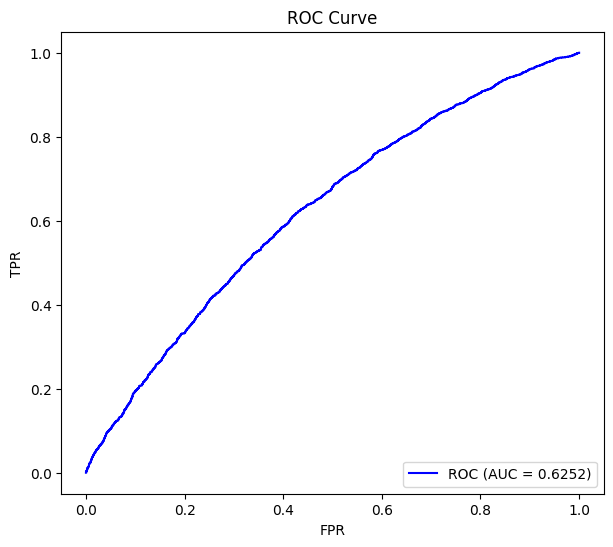

In [60]:
values_train_cw, labels_train_cw = form_detection_data(md_clean_train, md_cw_train, ndim=True)
values_test_cw, labels_test_cw = form_detection_data(md_clean_test, md_cw_test, ndim=True)
detector_cw_md = train_detector(values_train_cw, labels_train_cw)
probs = torch.tensor(detector_cw_md.predict_proba(values_test_cw)[:, 1])
fpr_md_cw, tpr_md_cw, auc_score_md_cw = compute_roc(labels_test_cw, probs, plot=True)

## Comparision of auc-roc

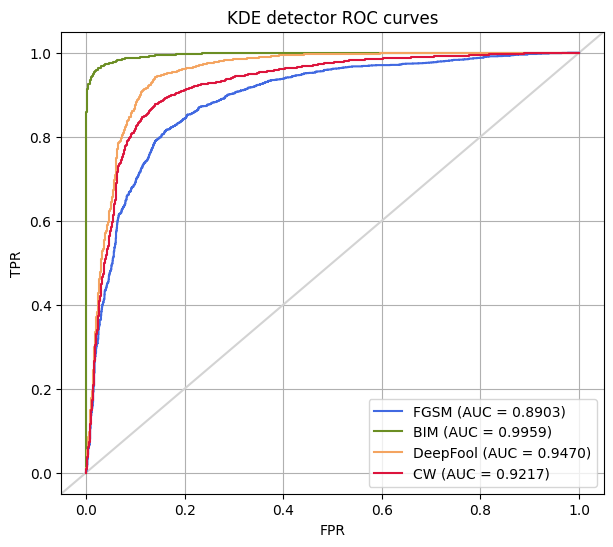

In [61]:
plt.figure(figsize=(7, 6))
plt.axline((0.0, 0.0), slope=1, color='lightgray')
plt.plot(fpr_kd_fgsm, tpr_kd_fgsm, color='royalblue',
        label='FGSM (AUC = %0.4f)' % auc_score_kd_fgsm)
plt.plot(fpr_kd_bim, tpr_kd_bim, color='olivedrab',
        label='BIM (AUC = %0.4f)' % auc_score_kd_bim)
plt.plot(fpr_kd_deepfool, tpr_kd_deepfool, color='sandybrown',
        label='DeepFool (AUC = %0.4f)' % auc_score_kd_deepfool)
plt.plot(fpr_kd_cw, tpr_kd_cw, color='crimson',
        label='CW (AUC = %0.4f)' % auc_score_kd_cw)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("KDE detector ROC curves")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

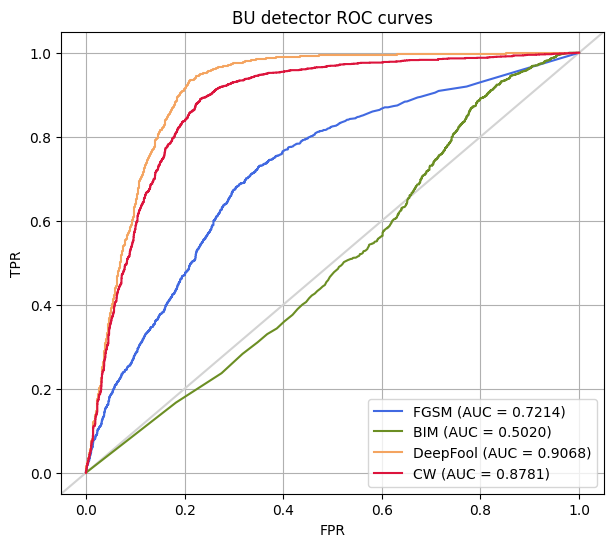

In [62]:
plt.figure(figsize=(7, 6))
plt.axline((0.0, 0.0), slope=1, color='lightgray')
plt.plot(fpr_bu_fgsm, tpr_bu_fgsm, color='royalblue',
        label='FGSM (AUC = %0.4f)' % auc_score_bu_fgsm)
plt.plot(fpr_bu_bim, tpr_bu_bim, color='olivedrab',
        label='BIM (AUC = %0.4f)' % auc_score_bu_bim)
plt.plot(fpr_bu_deepfool, tpr_bu_deepfool, color='sandybrown',
        label='DeepFool (AUC = %0.4f)' % auc_score_bu_deepfool)
plt.plot(fpr_bu_cw, tpr_bu_cw, color='crimson',
        label='CW (AUC = %0.4f)' % auc_score_bu_cw)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("BU detector ROC curves")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

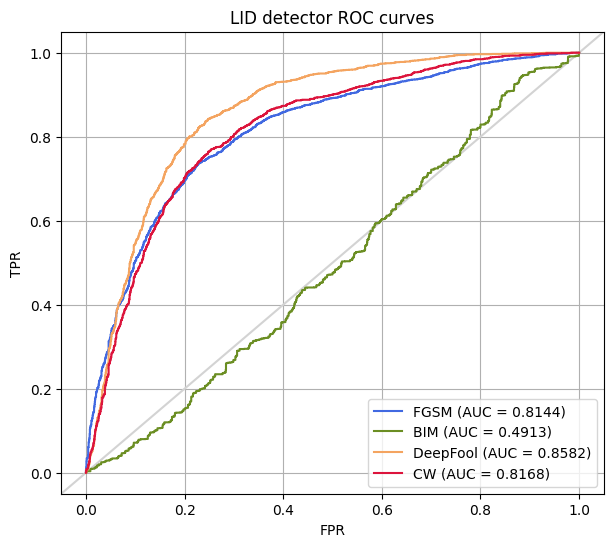

In [100]:
plt.figure(figsize=(7, 6))
plt.axline((0.0, 0.0), slope=1, color='lightgray')
plt.plot(fpr_lid_fgsm, tpr_lid_fgsm, color='royalblue',
        label='FGSM (AUC = %0.4f)' % auc_score_lid_fgsm)
plt.plot(fpr_lid_bim, tpr_lid_bim, color='olivedrab',
        label='BIM (AUC = %0.4f)' % auc_score_lid_bim)
plt.plot(fpr_lid_deepfool, tpr_lid_deepfool, color='sandybrown',
        label='DeepFool (AUC = %0.4f)' % auc_score_lid_deepfool)
plt.plot(fpr_lid_cw, tpr_lid_cw, color='crimson',
        label='CW (AUC = %0.4f)' % auc_score_lid_cw)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("LID detector ROC curves")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

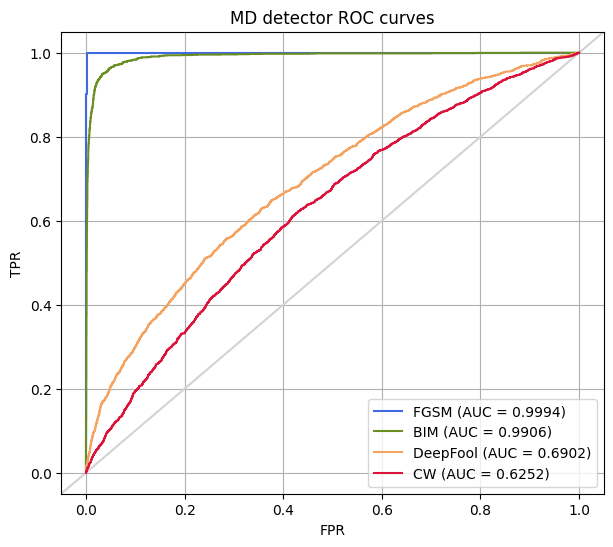

In [64]:
plt.figure(figsize=(7, 6))
plt.axline((0.0, 0.0), slope=1, color='lightgray')
plt.plot(fpr_md_fgsm, tpr_md_fgsm, color='royalblue',
        label='FGSM (AUC = %0.4f)' % auc_score_md_fgsm)
plt.plot(fpr_md_bim, tpr_md_bim, color='olivedrab',
        label='BIM (AUC = %0.4f)' % auc_score_md_bim)
plt.plot(fpr_md_deepfool, tpr_md_deepfool, color='sandybrown',
        label='DeepFool (AUC = %0.4f)' % auc_score_md_deepfool)
plt.plot(fpr_md_cw, tpr_md_cw, color='crimson',
        label='CW (AUC = %0.4f)' % auc_score_md_cw)
plt.legend(loc='lower right')
plt.grid(True)
plt.title("MD detector ROC curves")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

## Saving detectors for future research

In [101]:
def save_detector(detector, method_name, attack_name):
    filename = method_name + '_' + attack_name + '_' + 'detector.pkl'
    joblib.dump(detector, filename)

In [102]:
def load_detector(method_name, attack_name):
    filename = f'{method_name}_{attack_name}_detector.pkl'
    return joblib.load(filename)

In [103]:
save_detector(detector_fgsm_kde, 'kde', 'fgsm')
save_detector(detector_bim_kde, 'kde', 'bim')
save_detector(detector_deepfool_kde, 'kde', 'deepfool')
save_detector(detector_cw_kde, 'kde', 'cw')
save_detector(detector_fgsm_bu, 'bu', 'fgsm')
save_detector(detector_bim_bu, 'bu', 'bim')
save_detector(detector_deepfool_bu, 'bu', 'deepfool')
save_detector(detector_cw_bu, 'bu', 'cw')
save_detector(detector_fgsm_lid, 'lid', 'fgsm')
save_detector(detector_bim_lid, 'lid', 'bim')
save_detector(detector_deepfool_lid, 'lid', 'deepfool')
save_detector(detector_cw_lid, 'lid', 'cw')
save_detector(detector_fgsm_md, 'md', 'fgsm')
save_detector(detector_bim_md, 'md', 'bim')
save_detector(detector_deepfool_md, 'md', 'deepfool')
save_detector(detector_cw_md, 'md', 'cw')